# Case Study Operations - Image Analysis

Deep learning for lung disease discovery in CT scans.
- Can we identify diseases in chest CT scans?
- Can we discover which disease a sick patient has?

Methods employed:
- Analysis of data
- Deep Learning with ResNET

Tools and frameworks that I used:
- Pandas
- Numpy
- Matplotlib, Seaborn
- Res

*Data and inspiration from: https://www.udemy.com/course/data-science-for-business-6-real-world-case-studies/*

## 1. Data Import and Discovery

- Generate image generator model from image training data
- Create data split for training and cross-validation

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler

X_Ray_Dir = './Dataset'
#os.listdir(X_Ray_Dir) # List categories / image sub-directories
image_generator = ImageDataGenerator(rescale=1./255, validation_split=0.2)
train_generator = image_generator.flow_from_directory(batch_size=40, directory=X_Ray_Dir, shuffle=True,
                                                      target_size=(256,256), class_mode='categorical', subset='training')
validation_generator = image_generator.flow_from_directory(batch_size=40, directory=X_Ray_Dir, shuffle=True,
                                                      target_size=(256,256), class_mode='categorical', subset='validation')
train_images, train_labels = next(train_generator)
#train_images.shape
#train_labels.shape
label_names = {0:'Covid-19', 1:'Healthy', 2:'Viral Pneumonia', 3:'Bacterial Pneuomina'}

Found 428 images belonging to 4 classes.
Found 104 images belonging to 4 classes.


## 2. Data Visualization


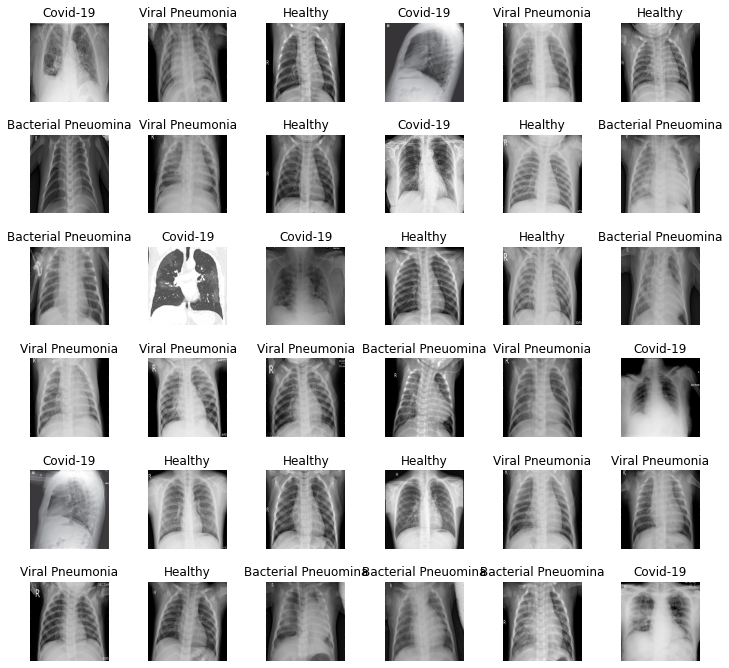

In [2]:
L = 6
W = 6

fig, axes = plt.subplots(L, W, figsize=(12,12))
axes = axes.ravel()

for i in np.arange(0, L*W):
    axes[i].imshow(train_images[i])
    axes[i].set_title(label_names[np.argmax(train_labels[i])])
    axes[i].axis('off')

plt.subplots_adjust(wspace=0.5);

## 3. Import Model with Pre-trained Weights

- Import pretrained ResNet50 model
- Fix weights for ResNet layers, except classification head

In [3]:
basemodel = ResNet50(weights='imagenet', include_top=False, input_tensor=layers.Input(shape=(256,256,3)))

for layer in basemodel.layers[:-10]:
    layer.trainable = False

basemodel.summary()
#tf.keras.utils.plot_model(basemodel)

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

## 4. Build and Train Model

- Take over output from base model as new input
- Add head model with layers for customized categorization
  - Dropout layers to improve generalizing power of net
- Early stopping if overfitting to training data happens


In [34]:
headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size=(4,4))(headmodel)
headmodel = Flatten(name='flatten')(headmodel)
headmodel = Dense(256, activation='relu')(headmodel)
headmodel = Dropout(0.3)(headmodel)
# Second Dense & Dropout layers with 256/0.3 instead of 128/0.2 improves model??
headmodel = Dense(256, activation='relu')(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(4, activation='softmax')(headmodel)

model = Model(inputs=basemodel.input, outputs=headmodel)
model.compile(loss='categorical_crossentropy', optimizer=optimizers.RMSprop(lr=1e-4, decay=1e-6), metrics=['accuracy'])

earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=20)
checkpointer = ModelCheckpoint(filepath='weights.hdf5', verbose=1, save_best_only=True)

train_generator = image_generator.flow_from_directory(batch_size=4, directory=X_Ray_Dir, shuffle=True,
                                                      target_size=(256,256), class_mode='categorical', subset='training')
val_generator = image_generator.flow_from_directory(batch_size=4, directory=X_Ray_Dir, shuffle=True,
                                                      target_size=(256,256), class_mode='categorical', subset='validation')

history = model.fit(train_generator, epochs=10, steps_per_epoch=train_generator.n//4, validation_data=val_generator,
                    validation_steps=val_generator.n//4, callbacks=[checkpointer, earlystopping])

Found 428 images belonging to 4 classes.
Found 104 images belonging to 4 classes.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 107 steps, validate for 26 steps
Epoch 1/10
106/107 [============================>.] - ETA: 0s - loss: 0.5959 - accuracy: 0.7830
Epoch 00001: val_loss improved from inf to 2.26890, saving model to weights.hdf5
107/107 [==============================] - 15s 141ms/step - loss: 0.5909 - accuracy: 0.7850 - val_loss: 2.2689 - val_accuracy: 0.2500
Epoch 2/10
106/107 [============================>.] - ETA: 0s - loss: 0.1121 - accuracy: 0.9623
Epoch 00002: val_loss did not improve from 2.26890
107/107 [==============================] - 9s 85ms/step - loss: 0.1147 - accuracy: 0.9603 - val_loss: 2.4340 - val_accuracy: 0.2500
Epoch 3/10
106/107 [============================>.] - ETA: 0s - loss: 0.0464 - accuracy: 0.9835
Epoch 00003: val_loss improved from 2.26890 to 2.00965, saving model to weights.hdf5
107/107 [==============================] - 10s 96ms/st

## 5. Evaluate Model


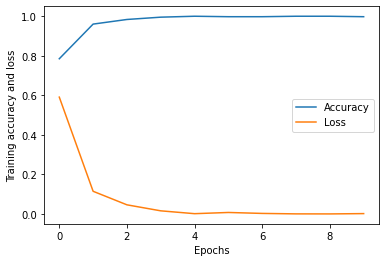

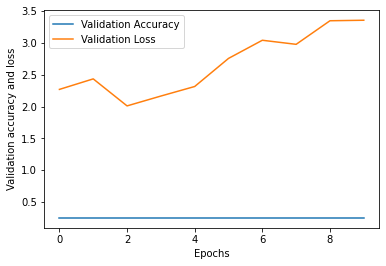

In [35]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Training accuracy and loss')
plt.legend(labels=['Accuracy','Loss'])
plt.show()
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Validation accuracy and loss')
plt.legend(labels=['Validation Accuracy','Validation Loss']);

In [36]:
test_dir = './Test'
test_gen = ImageDataGenerator(rescale=1.2/255)
test_generator = test_gen.flow_from_directory(batch_size=4, directory=test_dir, shuffle=True, target_size=(256,256),
                                              class_mode='categorical')
evaluate = model.evaluate(test_generator, steps=test_generator.n//4, verbose=1)
print('Accuracy Test: {}'.format(evaluate[1]))

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

prediction = []
original = []
image = []

# Iterate throu
for i ind range(len(os.listdir(test_dir))):
    for item in os.listdir(os.path.join(test_dir,str(i)))

Found 40 images belonging to 4 classes.
  ...
    to  
  ['...']
10/10 [==============================] - 1s 102ms/step - loss: 3.3150 - accuracy: 0.2500
Accuracy Test: 0.25


In [41]:
os.listdir(test_dir)
os.listdir(os.path.join(test_dir,str(0)))

['0', '1', '2', '3']

['1-s2.0-S0929664620300449-gr2_lrg-b.jpg',
 'auntminnie-b-2020_01_28_23_51_6665_2020_01_28_Vietnam_coronavirus.jpeg',
 'auntminnie-d-2020_01_28_23_51_6665_2020_01_28_Vietnam_coronavirus.jpeg',
 'nCoV-radiol.2020200269.fig1-day7.jpeg',
 'nejmoa2001191_f1-PA.jpeg',
 'nejmoa2001191_f4.jpeg',
 'radiol.2020200490.fig3.jpeg',
 'ryct.2020200028.fig1a.jpeg',
 'ryct.2020200034.fig5-day0.jpeg',
 'ryct.2020200034.fig5-day7.jpeg']